In [69]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif
import src.utils.sequence as utils

import scipy as sp
from matplotlib import pyplot as plt
%matplotlib inline
# import wandb # This is optional 
# wandb.login(host = "https://genentech.wandb.io" )

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load pre-trained model 

In [70]:
class ModelParameters:
    diffusion_weights_file = 'artifacts/MPRA-dataset:v2/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    # checkpoint_path = '../../save_models/hepg2_continuous/V1/-4_10/_2024.07.19_20.24.21/diffusion_epoch=095-average-loss=0.29.ckpt'
    checkpoint_path = '../../save_models/hepg2_continuous/V2/-1_4-lr=1e-3/_2024.07.21_15.05.16/diffusion_epoch=156-average-loss=0.30.ckpt'
    
    time_schedule = 'artifacts/MPRA-dataset:v2/time_dependent.npz'
config = ModelParameters() 

DEVICE = "cuda:4"

In [71]:
# Load Reward model
from grelu.lightning import LightningModel

reward_model = LightningModel.load_from_checkpoint(
    "../../save_models/eval_reward_models/hepg2_regressor.ckpt"
)
reward_model.eval()
reward_model.to(DEVICE)

wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


LightningModel(
  (model): EnformerPretrainedModel(
    (embedding): EnformerTrunk(
      (conv_tower): EnformerConvTower(
        (blocks): ModuleList(
          (0): Sequential(
            (0): Conv1d(4, 768, kernel_size=(15,), stride=(1,), padding=same)
            (1): ConvBlock(
              (norm): Norm(
                (layer): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              )
              (conv): Conv1d(768, 768, kernel_size=(1,), stride=(1,), padding=same)
              (act): Activation(
                (layer): GELU()
              )
              (pool): Pool(
                (layer): AttentionPool(
                  (pool_fn): Rearrange('b d (n p) -> b d n p', p=2)
                  (to_attn_logits): Conv2d(768, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
                )
              )
              (dropout): Dropout(
                (layer): Identity()
              )
              (channel_transform): ChannelT

In [72]:
original_model = lightning_dif.load_from_checkpoint(
        checkpoint_path=config.checkpoint_path, 
        weight_file=config.diffusion_weights_file, 
        time_schedule=config.time_schedule, 
        augment=False,
        continuous=True,
        y_low=-1.0,
        y_high=4.0
    )

original_model = original_model.model
original_model.cuda(device = DEVICE)

AugmentedScoreNet_Continuous(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), p

In [73]:
# checkpoint = torch.load(config.checkpoint_path, map_location=torch.device('cpu'))

# print(checkpoint['state_dict'].keys())

In [74]:
# time_dependent_weights = torch.tensor(np.load(config.time_schedule)['x'])

# original_model = modeld.AugmentedScoreNet_Continuous(
#                 time_dependent_weights=torch.sqrt(time_dependent_weights),
#                 y_low=-4.0,
#                 y_high=10.0,
#                 augment = False
#             )

# # print(checkpoint['state_dict'].keys())

# original_model.cuda(device = DEVICE)

# Evaluation 

In [75]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler

strength = 20

condition = torch.empty(128, device=DEVICE).uniform_(-1, 4)

allsamples_original = []

original_model.eval()

for t in range(5):
    samples=[]
    samples.append(sampler(original_model,
                        (200, 4),
                        existing_condition = condition,
                        class_number = 0,
                        strength = strength, 
                        batch_size = 128,
                        max_time =  4.0,
                        min_time = 1.0/400,
                        time_dilation = 1,
                        num_steps = 100, 
                        eps = 1e-5,
                        speed_balanced = True,
                        device = DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

In [76]:
allsamples_condition = np.concatenate(allsamples_original, axis=1)[0,:,:,:]

In [77]:
allsamples_condition.shape

(640, 200, 4)

In [78]:
all_rewards = []
data_loader = torch.utils.data.DataLoader(
        allsamples_condition.astype("float32"), 
        batch_size=128 , 
        num_workers=0
    )
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    # batch = (batch < 0.5) * torch.zeros_like(batch)
    
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    all_rewards.append(reward_model(batch).detach().cpu() ) 

all_rewards = np.concatenate(all_rewards)

In [79]:
hepg2_scores = all_rewards[:,0,0]
print(hepg2_scores.shape)

hepg2_scores = list(hepg2_scores)

(640,)


In [80]:
condition = list(condition.cpu().detach().numpy())*5
print(len(condition))

640


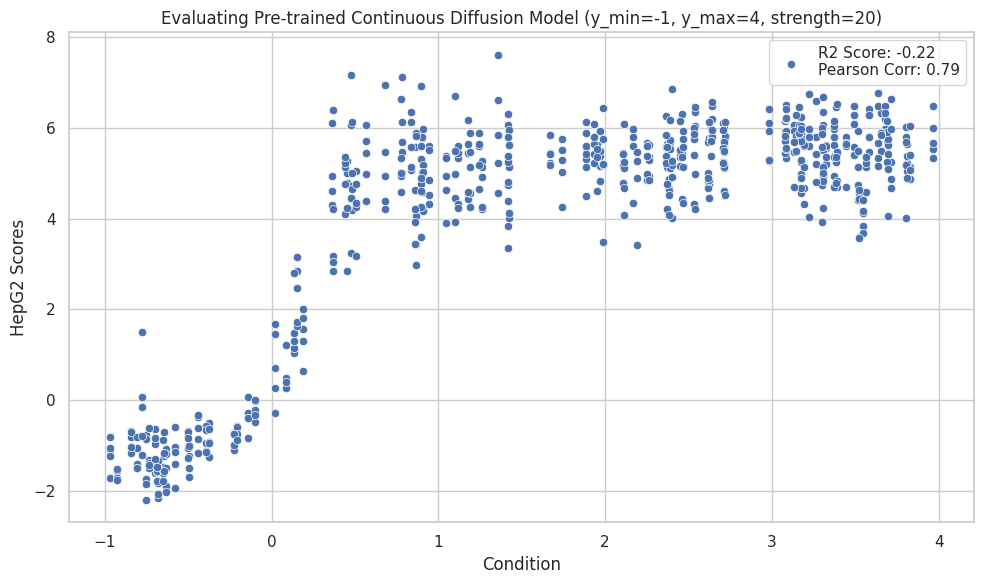

In [81]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

sns.set(style="whitegrid")

# Create a DataFrame from the lists
data = pd.DataFrame({
    'condition': condition,
    'hepg2_scores': hepg2_scores
})

# Calculate R-squared and Pearson correlation coefficient
r2 = r2_score(data['hepg2_scores'], data['condition'])
pearson_corr, _ = pearsonr(data['hepg2_scores'], data['condition'])

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=data, x='condition', y='hepg2_scores')

# Adding the R2 and Pearson correlation values to the legend
plt.legend(
    labels=[f'R2 Score: {r2:.2f}\nPearson Corr: {pearson_corr:.2f}'],
    loc='upper right'
)

# Setting labels
plt.xlabel('Condition')
plt.ylabel('HepG2 Scores')
plt.title(f'Evaluating Pre-trained Continuous Diffusion Model (y_min=-1, y_max=4, strength={strength})')
plt.tight_layout()

plt.savefig(f"../../media/Eval-continuous/strength={strength}_y_min=-1_y_max=4_v2.png")

# Display the plot
plt.show()